# Sarcasm Detection using Tensorflow

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

**Content**
Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

### Load the json data

In [39]:
import json
import numpy as np

def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

datastore = list(parse_data('resources/Sarcasm_Headlines_Dataset.json'))

In [40]:
# define the attribues from the json data
sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

### Now we have the relevant fields from the json in individual lists.. we would use the one which needed

In [41]:
# Define some hyper parameters
vocab_size = 1000
embedding_dim = 32
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<oov>'
training_size = 20000

In [42]:
# Split into training and validation data
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:20000]
testing_labels = labels[20000:]

# Convert labels to numpy array for feeding into neural network
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Build and train the Neural Network model

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 32)           32000     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 32,817
Trainable params: 32,817
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/30
625/625 [==============================] - 1s 1ms/step - loss: 0.6751 - accuracy: 0.5726 - val_loss: 0.5184 - val_accuracy: 0.7719
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.4618 - accuracy: 0.7981 - val_loss: 0.4227 - val_accuracy: 0.8034
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3924 - accuracy: 0.8225 - val_loss: 0.4052 - val_accuracy: 0.8126
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3721 - accuracy: 0.8312 - val_loss: 0.4027 - val_accuracy: 0.8147
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3638 - accuracy: 0.8354 - val_loss: 0.4014 - val_accuracy: 0.8158
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3568 - accuracy: 0.8399 - val_loss: 0.4045 - val_accuracy: 0.8101
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3547 - accuracy: 0.8398 - val_loss: 0.4028 - val_accuracy: 0.8147
Epoch 

### Evaluate the accuracy and loss

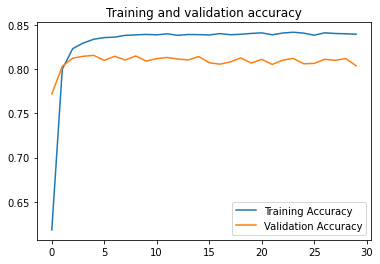

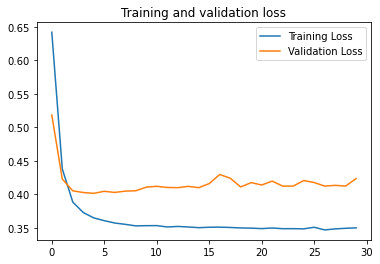

In [46]:
import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, label='Training Accuracy' )
plt.plot  ( epochs, val_acc, label='Validation Accuracy' )
plt.title ('Training and validation accuracy')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, label='Training Loss' )
plt.plot  ( epochs, val_loss, label='Validation Loss' )
plt.title ('Training and validation loss'   )
plt.legend()
plt.show()

### Now we will evaluate with a new sentence

In [47]:
new_sentence = ["granny starting to fear spiders in the garden might be real",
                "game of thrones season finale showing this sunday night"]

new_sequence = tokenizer.texts_to_sequences(new_sentence)
new_pad = pad_sequences(new_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(new_pad))

[[0.2683537 ]
 [0.48872644]]
